In [1]:
#Basic Tools Boxes
from scipy.interpolate import griddata
import pandas as pd
from pandas import *
import numpy as np
import xarray as xr
import datetime as dt
from scipy import signal
from scipy import interpolate
import re
import glob
import os

# GSW Tool Box
import gsw as gs

# Plot toolbox
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as ticker
import matplotlib.pylab as plt
from matplotlib import gridspec
import matplotlib.dates as mdates
import matplotlib
import pyproj 

from scipy.ndimage.filters import gaussian_filter

In [8]:
### Convert lon lat to x y coordinates
P = pyproj.Proj(proj='utm', zone=31, ellps='WGS84', preserve_units=True)
def LonLat_To_XY(Lon,Lat):
    return P(Lon,Lat) 

def  get_position_distance(lons,lats): 
    x,y =LonLat_To_XY(lons,lats)
    dx = abs(np.diff(x)) ; dy=abs(np.diff(y))  
    dist_x = np.cumsum(dx)*1e-3; dist_y = np.cumsum(dy)*1e-3
    distance_cum = np.zeros (x.shape)
    distance_cum [1:]= np.sqrt(dist_x**2 + dist_y**2)
    delta_x = np.sqrt((dx*1e-3)**2+(dy*1e-3)**2)
    return(distance_cum,delta_x)


def field_template (var, dx, vdepth, ldepth, distance_cum):
    #idepth = np.where(vdepth == ldepth)
    idepth = ldepth
    field = xr.DataArray(np.squeeze(var[idepth]))
    ## Interpolate on a new grid xn, with a cubic function
    xo = distance_cum
    xn = np.arange(0, xo[-1], step = dx)
    f = interpolate.interp1d(xo, field, kind='linear')
    field_tmp = np.zeros(xn.shape)
    field_tmp = f(xn)
    return (xo, xn, field, field_tmp)


def make_FFT1D(field,t,dt):
    ss =field
    #FFT=np.fft.rfft(ss,ss.shape[0])
    FFT=np.fft.fft(ss,ss.shape[0])
    #FFT=np.fft.fftshift(FFT)

    #freq1=np.fft.rfftfreq(len(t),dt)
    freq1=np.fft.fftfreq(len(t),dt)
    #freq1=np.fft.fftshift(freq1)

    ###ATTENTION, FFTFREQ RETOURNE UNE FREQUENCE DONC 1/DX
    om=2*np.pi*freq1
    #FFT=FFT*dt
    FFT=FFT/np.sqrt(ss.shape[0])
    PSD=FFT*np.conj(FFT)
    
    dk=dt
            ## Sampling frequency
    fs = 1/(dk)
            ## Number of points to overlap between segments (50%)
    nperseg = len(field)
    noverlap = nperseg/2
            # PSD computation
    f_welch, PSD_welch = signal.welch(ss, fs, nperseg=nperseg,window='hann', noverlap=noverlap, return_onesided=True, detrend='linear')
 

    return FFT,om, PSD, 2*np.pi*f_welch, PSD_welch

def load_data_oce(file):
    xfile = xr.open_dataset(file, decode_times=False)
    ssh = np.squeeze(xfile.ssh.data)
    olon = xfile.nav_lon.data
    olat = xfile.nav_lat.data
    time = (xfile.time_counter.data)[0]
    depth = xfile.deptht.data
    temp = np.squeeze(xfile.votemper.data)
    sal = np.squeeze(xfile.vosaline.data)
    sigma = np.squeeze(xfile.rhop_sig0.data)
    return(olon,olat,time,depth,ssh,temp,sigma)

def load_data_u(file):
    xfile = xr.open_dataset(file, decode_times=False)
    u = np.squeeze(xfile.vozocrtx.data)
    return(u)

def load_data_v(file):
    xfile = xr.open_dataset(file, decode_times=False)
    v = np.squeeze(xfile.vomecrty.data)
    return(v)

### PATH FOR CREG12 - FOR A SPECIFIC FILE

In [3]:
path_vars = '/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-REF08-S/5d/'
file_oce = sorted(glob.glob(path_vars+'2012/CREG12.L75-REF08_y2012m09'+'*gridT.nc'), key=os.path.getmtime)
file_u = sorted(glob.glob(path_vars+'2012/CREG12.L75-REF08_y2012m09'+'*gridU.nc'), key=os.path.getmtime)
file_v = sorted(glob.glob(path_vars+'2012/CREG12.L75-REF08_y2012m09'+'*gridV.nc'), key=os.path.getmtime)


### LOAD DATA :LON & LAT + HYDROGRAPHIC DATA + U & V

In [4]:
### LOAD DATA
[olon,olat,time,depth,ssh,temp,sigma]=load_data_oce(file_oce[0],)
u=load_data_u(file_u[0],)
v=load_data_v(file_v[0],)


### SPECIFY THE TRANSECT OF INTEREST
ind1 = 1444
ind2 = 810
borne = 200
lats = olat[ind1-borne:ind1+borne,ind2]
lons = olon[ind1-borne:ind1+borne,ind2]

### COMPUTE KE FOR THE TRANSECT OF INTEREST
ke = 1/2 *((u[:,ind1-borne:ind1+borne,ind2])**2+(v[:,ind1-borne:ind1+borne,ind2])**2)
#sigma_spec = sigma[:,ind1-borne:ind1+borne,ind2]

### VISUALISATION OF THE TRANSECT

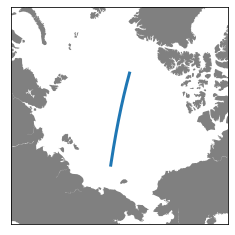

In [5]:
m = Basemap(width=4100000,height=4100000,
            resolution='l',projection='stere',\
            lat_ts=50,lon_0=olon[ind1,ind2],lat_0=olat[ind1,ind2])
m.fillcontinents(color='grey')
xx, yy = m(lons,lats)
plot5 = m.plot(xx,yy,linewidth=3)

### COMPUTE THE POWER DENSITY SPECTRUM OF A VARIABLE

In [9]:
ldepth = 1  ### THE DEPTH
dxx = 4.5   ### THE 
var = ke**2  ### THE VARIABLE

distance, dx = get_position_distance(lons,lats)
xo, xn, field, field_tmp = field_template(var, dxx, depth, ldepth, distance)
FFT,om, PSD, om_welch, PSD_welch = make_FFT1D(field_tmp,xn,dxx)

/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.
/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


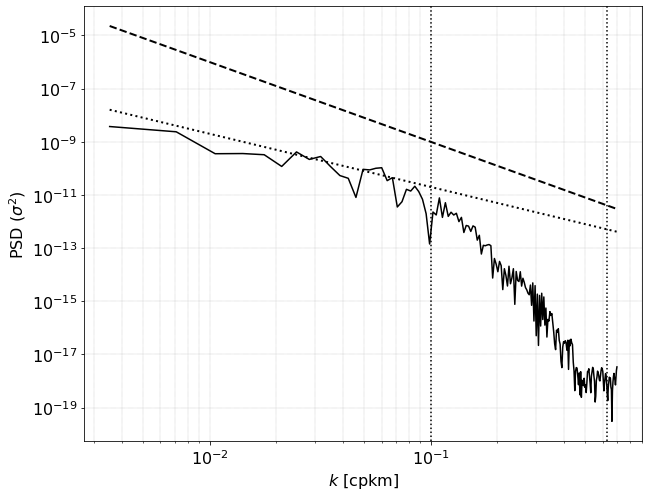

In [14]:
L1 = 10; L2 = 2*np.pi*L1

fontsize=16
fig = plt.figure(figsize=(10,8))
ax = plt.gca()

xaxis = om_welch

plt_spectre = plt.loglog(xaxis[1:],PSD_welch[1:], c='k')
plot_theo = plt.loglog(xaxis, 1*1e-12*xaxis**-3, linestyle='--',label='$\u03A9^{-3}$', color='k', linewidth = 2)
plt.loglog(xaxis, 2*1e-13*xaxis**-2, linestyle=':',label='$\u03A9^{-3}$', color='k', linewidth = 2)



plt.xlabel(r'$k$ [cpkm]', fontsize= fontsize )
plt.ylabel(r'PSD ($\sigma ^{2}$)', fontsize = fontsize )
#plt.ylabel(r'PSD ($KE$)', fontsize = fontsize )
ax.tick_params(labelsize=fontsize)
ax.grid(which='major', linestyle=':', linewidth='0.2', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
ax.axvline(x=2*np.pi*(1/L2),color='k', ls = ':')
ax.axvline(x=2*np.pi*(1/L1),color='k', ls = ':')

In [14]:
depth

array([5.0576001e-01, 1.5558553e+00, 2.6676817e+00, 3.8562799e+00,
       5.1403613e+00, 6.5430336e+00, 8.0925188e+00, 9.8227501e+00,
       1.1773680e+01, 1.3991038e+01, 1.6525322e+01, 1.9429802e+01,
       2.2757616e+01, 2.6558300e+01, 3.0874561e+01, 3.5740204e+01,
       4.1180023e+01, 4.7211895e+01, 5.3850636e+01, 6.1112839e+01,
       6.9021683e+01, 7.7611160e+01, 8.6929428e+01, 9.7041313e+01,
       1.0803028e+02, 1.2000000e+02, 1.3307582e+02, 1.4740625e+02,
       1.6316446e+02, 1.8054993e+02, 1.9978996e+02, 2.2114117e+02,
       2.4489062e+02, 2.7135638e+02, 3.0088751e+02, 3.3386282e+02,
       3.7068848e+02, 4.1179385e+02, 4.5762561e+02, 5.0863989e+02,
       5.6529230e+02, 6.2802600e+02, 6.9725867e+02, 7.7336829e+02,
       8.5667896e+02, 9.4744788e+02, 1.0458542e+03, 1.1519912e+03,
       1.2658615e+03, 1.3873770e+03, 1.5163636e+03, 1.6525685e+03,
       1.7956708e+03, 1.9452955e+03, 2.1010266e+03, 2.2624216e+03,
       2.4290251e+03, 2.6003804e+03, 2.7760393e+03, 2.9555703e